In [2]:
import os
import time
import shutil
import librosa
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve\
,auc
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
print(f'tensorflow version: {tf.__version__}')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

tensorflow version: 2.7.0


In [3]:
tqdm_notebook.pandas()

# import and convert to mfcc

In [7]:
train_df = pd.DataFrame(columns=['full_path', 'filename', 'mfcc', 'is_train', 'is_augmented', 'um_label'])
test_df = pd.DataFrame(columns=['full_path', 'filename', 'mfcc', 'is_train', 'is_augmented', 'um_label'])

In [8]:
path = 'dataset_clips'
for filename in os.listdir(f'{path}/train/true/'):
    new_row = {'full_path': f'{path}/train/true/', 'filename': filename, 'is_train': True, 'is_augmented': False, 'um_label': 1}
    train_df = train_df.append(new_row, ignore_index = True)

for filename in os.listdir(f'{path}/train/augmented_true/'):
    new_row = {'full_path': f'{path}/train/augmented_true/', 'filename': filename, 'is_train': True, 'is_augmented': True, 'um_label': 1}
    train_df = train_df.append(new_row, ignore_index = True)
    
for filename in os.listdir(f'{path}/train/false/'):
    new_row = {'full_path': f'{path}/train/false/', 'filename': filename, 'is_train': True, 'is_augmented': False, 'um_label': 0}
    train_df = train_df.append(new_row, ignore_index = True)

In [9]:
path = 'dataset_clips'
for filename in os.listdir(f'{path}/test/true/'):
    new_row = {'full_path': f'{path}/test/true/', 'filename': filename, 'is_train': False, 'is_augmented': False, 'um_label': 1}
    test_df = test_df.append(new_row, ignore_index = True)

for filename in os.listdir(f'{path}/test/false/'):
    new_row = {'full_path': f'{path}/test/false/', 'filename': filename, 'is_train': False, 'is_augmented': False, 'um_label': 0}
    test_df = test_df.append(new_row, ignore_index = True)

## Convert to MFCC

In [21]:
def extract_mfcc(df):
    try:
        audio, sr = librosa.load(f'{df["full_path"]}{df["filename"]}', sr=16000)
        mfcc = librosa.feature.mfcc(audio, sr, n_mfcc=13)
        return mfcc
    except:
        return None

In [22]:
%%time
train_df['mfcc'] = train_df.progress_apply(extract_mfcc, axis=1)
test_df['mfcc'] = test_df.progress_apply(extract_mfcc, axis=1)

  0%|          | 0/45370 [00:00<?, ?it/s]

CPU times: total: 7min 3s
Wall time: 6min 48s


In [46]:
X_train = np.stack(train_df['mfcc'].to_numpy())
y_train = train_df['um_label'].to_numpy().reshape(-1,1).astype('float32')

X_test = np.stack(test_df['mfcc'].to_numpy())
y_test = test_df['um_label'].to_numpy().reshape(-1,1).astype('float32')

In [48]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_shape

(13, 94, 1)

# Train model

In [50]:
def create_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (2,2), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [51]:
model = create_cnn_model(input_shape)

In [53]:
adam_optimizer = Adam(learning_rate=0.00005)

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam_optimizer)

In [54]:
%%time
num_epochs = 100
num_batch_size = 64

model_checkpoint = ModelCheckpoint(filepath='models/v5 (augmented).hdf5', 
                               verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

history = model.fit(X_train, 
          y_train, 
          batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(X_test, y_test), 
          callbacks=[model_checkpoint, early_stop], 
          verbose=1)

Epoch 1/100
609/610 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.6781
Epoch 00001: val_loss improved from inf to 0.54749, saving model to models\v5 (augmented).hdf5
610/610 [==============================] - 22s 36ms/step - loss: 0.6300 - accuracy: 0.6781 - val_loss: 0.5475 - val_accuracy: 0.7600
Epoch 2/100
609/610 [============================>.] - ETA: 0s - loss: 0.4973 - accuracy: 0.7582
Epoch 00002: val_loss improved from 0.54749 to 0.51847, saving model to models\v5 (augmented).hdf5
610/610 [==============================] - 21s 34ms/step - loss: 0.4973 - accuracy: 0.7583 - val_loss: 0.5185 - val_accuracy: 0.7733
Epoch 3/100
609/610 [============================>.] - ETA: 0s - loss: 0.4386 - accuracy: 0.7980
Epoch 00003: val_loss improved from 0.51847 to 0.46163, saving model to models\v5 (augmented).hdf5
610/610 [==============================] - 21s 34ms/step - loss: 0.4386 - accuracy: 0.7980 - val_loss: 0.4616 - val_accuracy: 0.8063
Epoch 4/100
608/6

# Test Model

In [70]:
model = create_cnn_model(input_shape)

model.load_weights('models/v4.hdf5')

In [71]:
def test_thresholds(X, y):
    fpr, tpr, thresholds = roc_curve(y, model.predict(X))
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    
    possible_thresholds = np.linspace(0, 1, num=20)
    df_metrics = pd.DataFrame()
    for threshold in possible_thresholds:
        y_pred = (model.predict(X) > threshold).astype("int32")
        df_metrics = df_metrics.append({
            'threshold': threshold,
            'accuracy': accuracy_score(y, y_pred),
            'f1_score': f1_score(y, y_pred)
        }, ignore_index=True)
        
    sns.lineplot(data=df_metrics.set_index('threshold'), palette="tab10", linewidth=2.5)
    
    return df_metrics

In [74]:
y_pred = (model.predict(X_test) > 0.38).astype("int32")
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'f1 score: {f1_score(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

Accuracy: 0.8957777428975043
f1 score: 0.7205387205387205


array([[4851,  320],
       [ 344,  856]], dtype=int64)

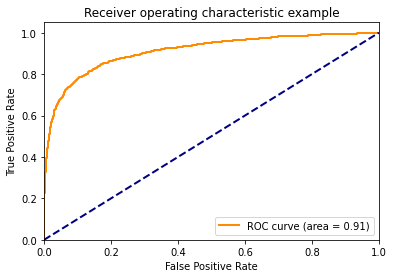

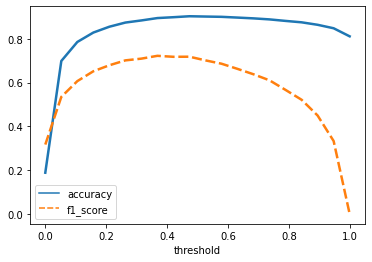

In [75]:
df_metrics = test_thresholds(X_test, y_test)